# ML lab 07

# Clustering

In [1]:
# Uncomment to upgrade packages
# !pip install pandas --upgrade --user --quiet
# !pip install numpy --upgrade --user --quiet
# !pip install scipy --upgrade --user --quiet
# !pip install statsmodels --upgrade --user --quiet
# !pip install scikit-learn --upgrade --user --quiet
# !pip install tensorflow --user
%load_ext autoreload

In [2]:
#%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
pd.set_option('display.precision', 3)
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Extra imports
from numpy.random import  uniform,normal
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from numpy.random import multivariate_normal
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from time import time
from datetime import timedelta

from tensorflow.keras.datasets import fashion_mnist

2023-04-14 13:23:44.338528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# turn off annoying warnings
import warnings
warnings.filterwarnings('ignore')

# for reproducibility
np.random.seed(7)

## SECTION 1. Clustering easy artificial 2D data 

First we create a simple data set:


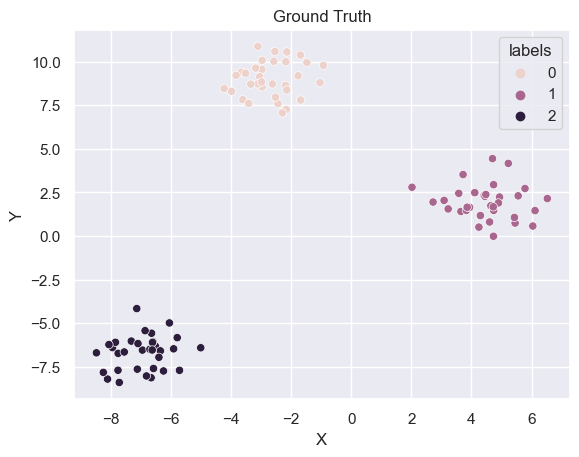

In [5]:
K = 3 
N = 100

data, labels = make_blobs(n_samples=N, n_features=2, centers=K, random_state=42)
data = pd.DataFrame(data, columns=['X', 'Y'])
data['labels'] = labels
sns.scatterplot(x='X', y='Y', hue='labels', data=data);
t = plt.title('Ground Truth');

 so we have 3 very clean clusters ...

Let's execute k-means

In [6]:
K = 3 # yeah, we are cheating .. why 3?

 execute k-means with a maximum of 100 iterations

In [7]:
kmeans_3 = KMeans(n_clusters=3, max_iter=100)
kmeans_3.fit(data.loc[:,['X','Y']]);
data['kmeans3_labels'] = kmeans_3.labels_

KMeans(max_iter=100, n_clusters=3)

plot and paint the clusters (according to the computed assignments) and plot the cluster centers

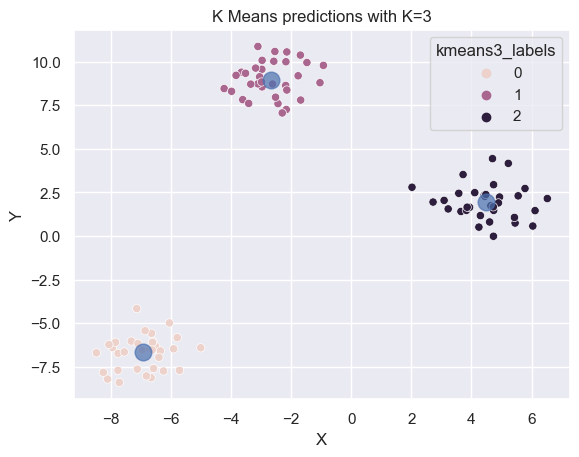

In [8]:
sns.scatterplot(x='X', y='Y', hue='kmeans3_labels', data=data);
plt.plot(kmeans_3.cluster_centers_[:,0], kmeans_3.cluster_centers_[:,1], 'bo', markersize=12,alpha=0.7);
plt.title('K Means predictions with K=3');

We can see here that the clusters correspond exactly to the ground truth, so we can say that we have a very good clustering model there. 
Usually we will not have the ground truth to compare with, and most times the data will have more than two dimensions, which difficults compare the clusters on a visualization. Also, on a real problem we will not know the best number of clusters.

To handle theses issues we will use metrics to decide if we have a good clustering or a bad one, and to chose between different models. 

### Metrics

We will use three different metrics to evaluate our perfect clustering. 

**Calinski-Harabasz index**: 

This index measures the dispersion of the data points within the clusters (SSW) and between the clusters (SSB)

A good clustering has small SSW (compact clusters) and large SSB (separated cluster centers). So we want a CH as big as possible.

There is also a correction for the number of clusters
 
The CH index is then:

 $$
 CH = \frac{SSB/(K-1)}{SSW/(N-K)}
 $$

 where $N$ is the number of data points and $K$ is the number of clusters.

In [9]:
index= pd.MultiIndex.from_arrays([['kmeans'], [3]], names=('model', 'K'))

results_df = pd.DataFrame(index=index, columns= ['CH score', 'Silhouette score', 'DB score'])

In [10]:
CH_3 = calinski_harabasz_score(data.loc[:,['X','Y']], kmeans_3.labels_ )

results_df.loc[('kmeans',3), 'CH score'] = CH_3
results_df

CH score Silhouette score DB score
model  K                                    
kmeans 3  1778.088              NaN      NaN

**Silhouette Coefficient**

This metric is based on distances between the clusters. It uses the Mean Intra cluster distance (I) and Mean Nearest Cluster distance (N) for each sample as $S_i = \frac{N_i-I_i}{max(N_i,I_i)}$. Then silhouette index is computed as the mean of all these values . 

$$
S = mean_i(S_i) = mean_i(\frac{N_i-I_i}{max(N_i,I_i)})
$$

The best value for this metric is 1 ($I=0, N>0$) and the worse value is -1 ($I>0, N=0$).

In [11]:
S_3 = silhouette_score(data.loc[:,['X','Y']], kmeans_3.labels_ )

results_df.loc[('kmeans', 3), 'Silhouette score'] = S_3
results_df

CH score Silhouette score DB score
model  K                                    
kmeans 3  1778.088            0.847      NaN

**Davies-Bouldin score**

Is defined as the average similarity measure for ach cluster with its most similar cluster. 

Similarity is computed as the ratio of within cluster distances to between cluster distances. 

The best value for this meassure is 0, which means condensed clusters far awai from each other. 

In [12]:
DB_3 = davies_bouldin_score(data.loc[:,['X','Y']], kmeans_3.labels_ )

results_df.loc[('kmeans', 3), 'DB score'] = DB_3
results_df

CH score Silhouette score DB score
model  K                                    
kmeans 3  1778.088            0.847    0.214

We can see here that, even though we have a perfect clustering acording to the ground truth, we have not obtained a perfect score on any of the metrics. 

This is because measuring the performance of an unsupervised is _difficult_. 
These metrics have been defined to try to measure some characteristics that we asociate to a good clustering, but they will not alwais be the best for each context.   

Now let's not _"cheat"_ choosing the best k. We are going to try some k values and see their clustering results.

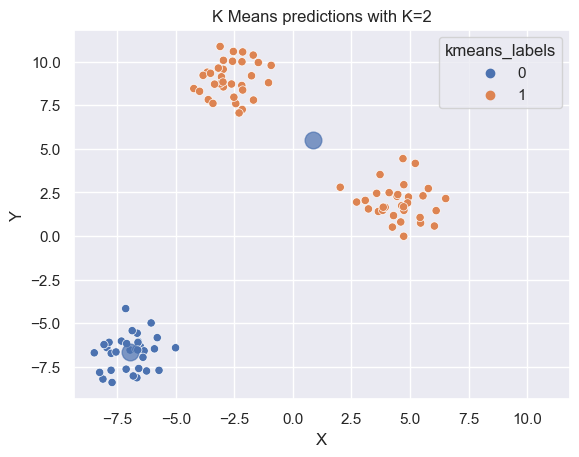

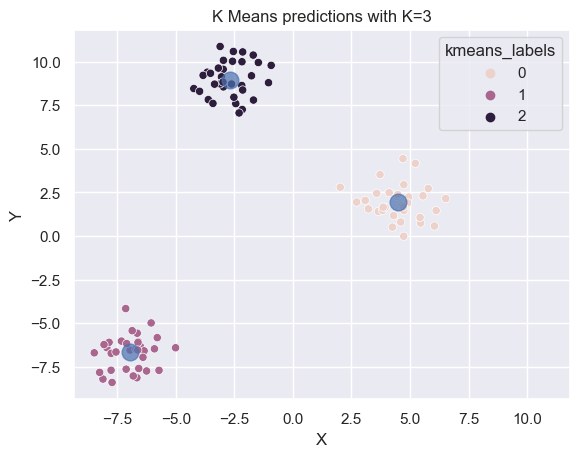

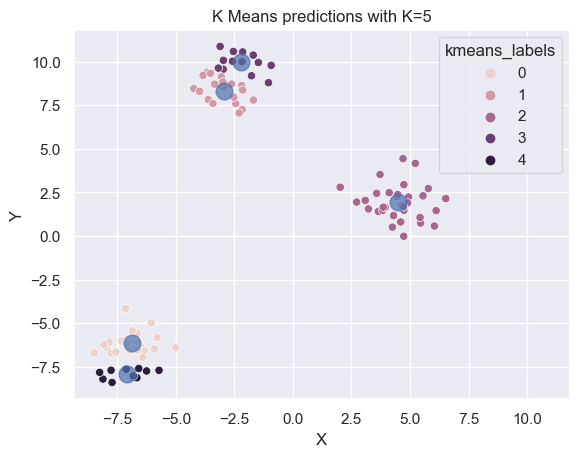

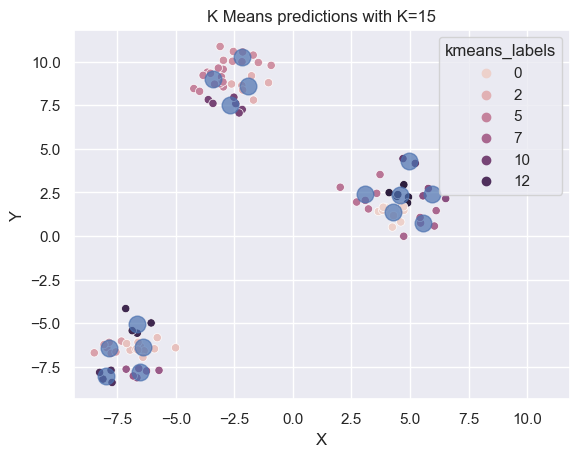

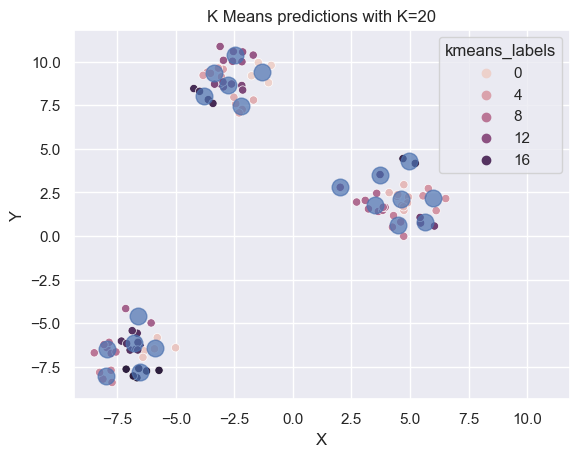

In [13]:
def compute_clustering_and_plot(K, data, results):

    # Train the model with k-means with given K
    kmeans = KMeans(n_clusters=K, max_iter=100)
    kmeans.fit(data.loc[:,['X','Y']]);
    data['kmeans_labels'] = kmeans.labels_

    # Plot results
    sns.scatterplot(x='X', y='Y', hue='kmeans_labels', data=data);
    plt.plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 'bo', markersize=12,alpha=0.7);
    plt.xlim(plt.ylim());
    plt.title(f'K Means predictions with K={K}');
    plt.show();

    # Compute metrics
    CH = calinski_harabasz_score(data.loc[:,['X','Y']], kmeans.labels_ )
    S = silhouette_score(data.loc[:,['X','Y']], kmeans.labels_ )
    DB = davies_bouldin_score(data.loc[:,['X','Y']], kmeans.labels_ )
    
    # store metrics
    results.loc[('kmeans', k),:] = [CH,S,DB]
    return results

K_values = [2,3,5,15,20]

for k in K_values:
    results = compute_clustering_and_plot(k, data,results_df)

In [14]:
results_df.sort_values(by='CH score', ascending=False)

CH score Silhouette score DB score
model  K                                     
kmeans 3   1778.088            0.847    0.214
       5   1214.511            0.532    0.807
       20  1200.136            0.392    0.675
       15  1072.888            0.382    0.746
       2      244.6            0.702    0.431

We can see on our results that according to all three metrics the best value for K is 3. Well done K-means! But this was very easy data to cluster..

***

## SECTION 2. Clustering not-so-easy artificial 2D data with k-means and E-M

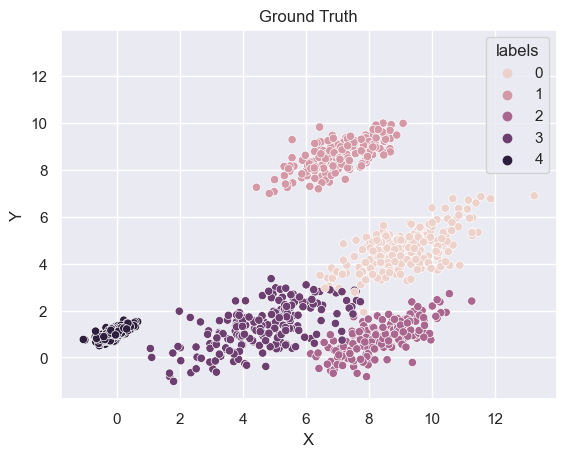

In [15]:
np.random.seed(0)

K = 5
N = 1000
center = np.array((0,0))
dispersion = 25

# get random centers
mu_k= multivariate_normal(center, np.eye(2)*dispersion,K)
# get random standard devs for each cluster
sigma_k = uniform(0.2, 1.5, size=K)
# create clusters (with isotropic Gaussians); same density each cluster (N/5 points in each)
data, labels = make_blobs(n_samples=N, n_features=2, centers=mu_k, cluster_std=sigma_k)

# Rotate and scale (all clusters equally..)
linear_transform =  np.array([[1,0.4],[0.2,0.6]])
data = np.dot(data, linear_transform) 
mu_k= np.dot(mu_k, linear_transform)

data = pd.DataFrame(data, columns=['X', 'Y'])
data['labels']=labels

# plot generated data
sns.scatterplot(x='X', y='Y',hue='labels', data=data);
plt.ylim(plt.xlim());
plt.title('Ground Truth');

generate 2D data as a mixture of 5 Gaussians, The rotation makes the two variable non independent with different variances

Lets have a look at the unconditional density p(x) by computing the 2D kernel density. This is the raw data (what the clustering method sees) and a contour plot of the unconditional density. 

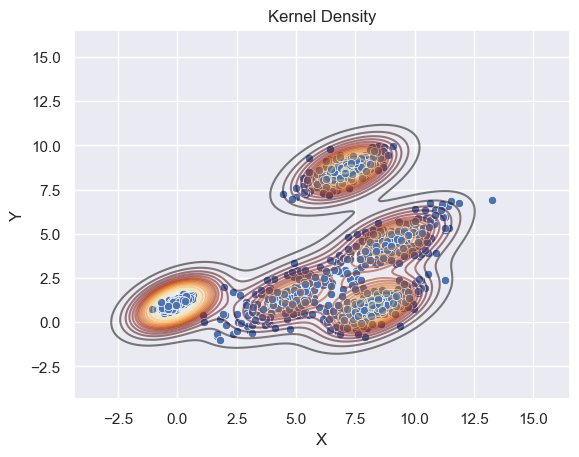

In [16]:
sns.scatterplot(x='X', y='Y', data=data);
plt.title('Kernel Density');
p = sns.kdeplot(x='X', y='Y', data=data, n_levels=15, cmap='afmhot', alpha=0.5);
plt.ylim(plt.xlim());


If we were working with real data we would not have labels for our samples. Let's try to find the best clustering for  our data without using this information.

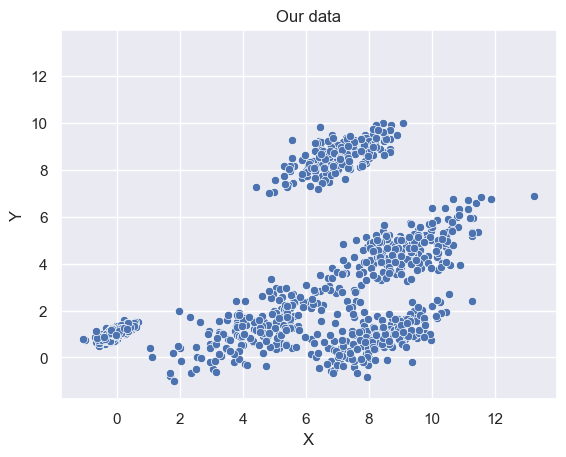

In [17]:
p = sns.scatterplot(x='X', y='Y', data=data);
plt.ylim(plt.xlim());
plt.title('Our data');

Let us try first with k-means:

In [18]:
index= pd.MultiIndex.from_arrays([['kmeans'], [3]], names=('model', 'K'))

results_df2 = pd.DataFrame(index=index, columns= ['CH score', 'Silhouette score', 'DB score'])

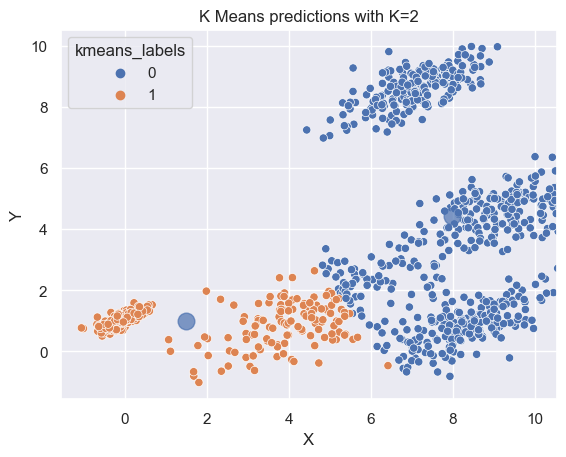

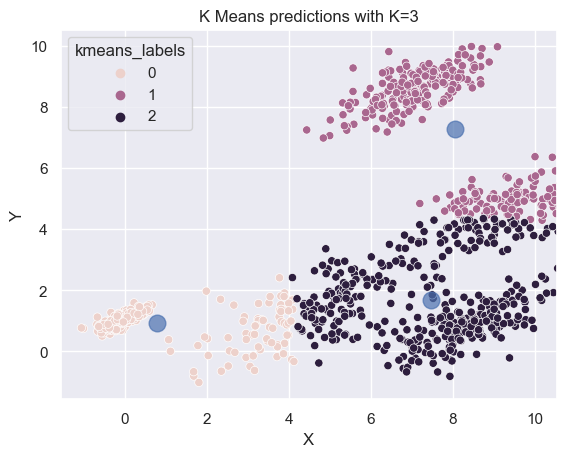

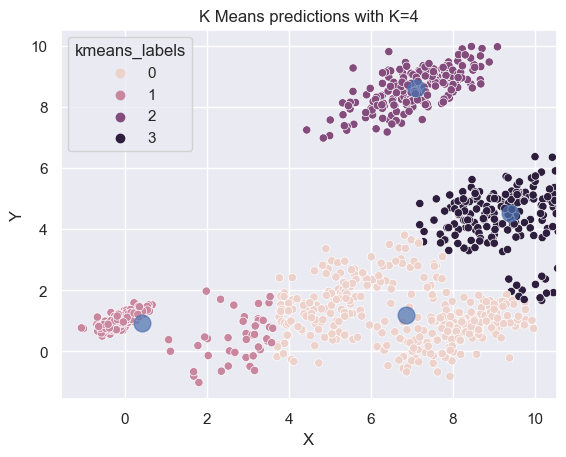

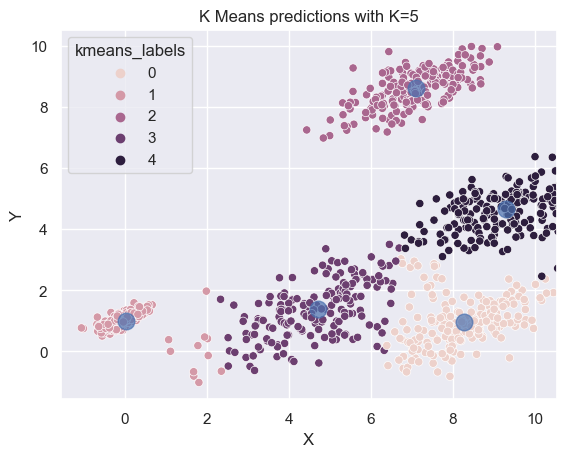

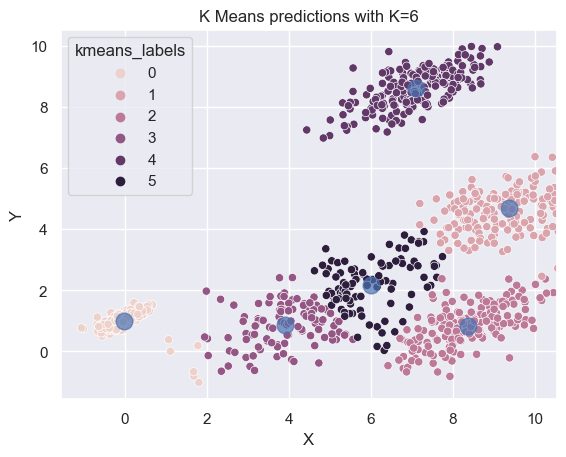

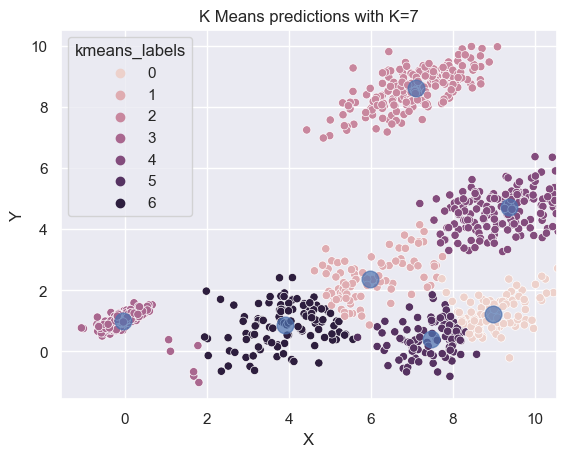

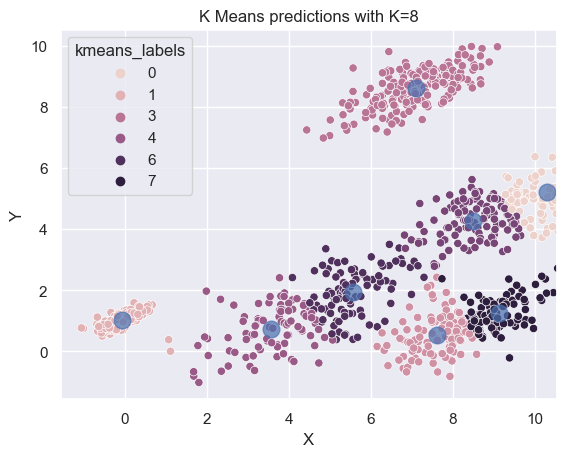

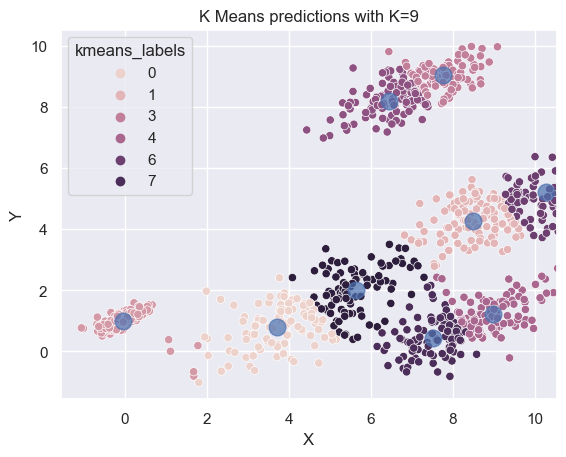

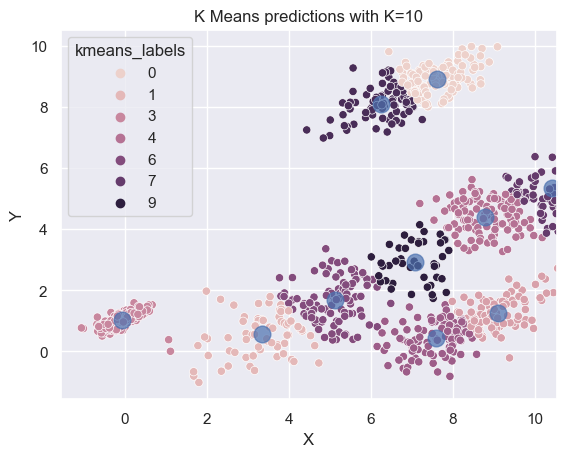

In [19]:
K_values = [2,3,4,5,6,7,8,9,10]


for k in K_values:
    results_df2 = compute_clustering_and_plot(k, data, results_df2)

In [20]:
results_df2.sort_values(by='CH score', ascending=False)

CH score Silhouette score DB score
model  K                                     
kmeans 10  4008.546            0.505    0.754
       9   3928.687            0.506     0.77
       5   3839.843            0.641    0.522
       8   3758.701            0.561    0.713
       6    3728.82            0.617    0.605
       7   3576.659            0.592    0.637
       4    2682.17             0.59    0.592
       3   2030.575            0.543    0.661
       2    1230.73            0.511    0.713

Now our metrics are not so sure.Silhouette and DB metrics agree that the best k is 5 but according to CH score the best K would be 10.

How can this be happening? 

CH score on the other hand is being tricked more smaller clusters as points are closer to their centroids this way. 

If we check the evolution of our metrics when we increase the k we can see that according to CH score k=5 would be a good candidate, as there is not a lot of difference on the performance betwen k=5 and k > 5. 

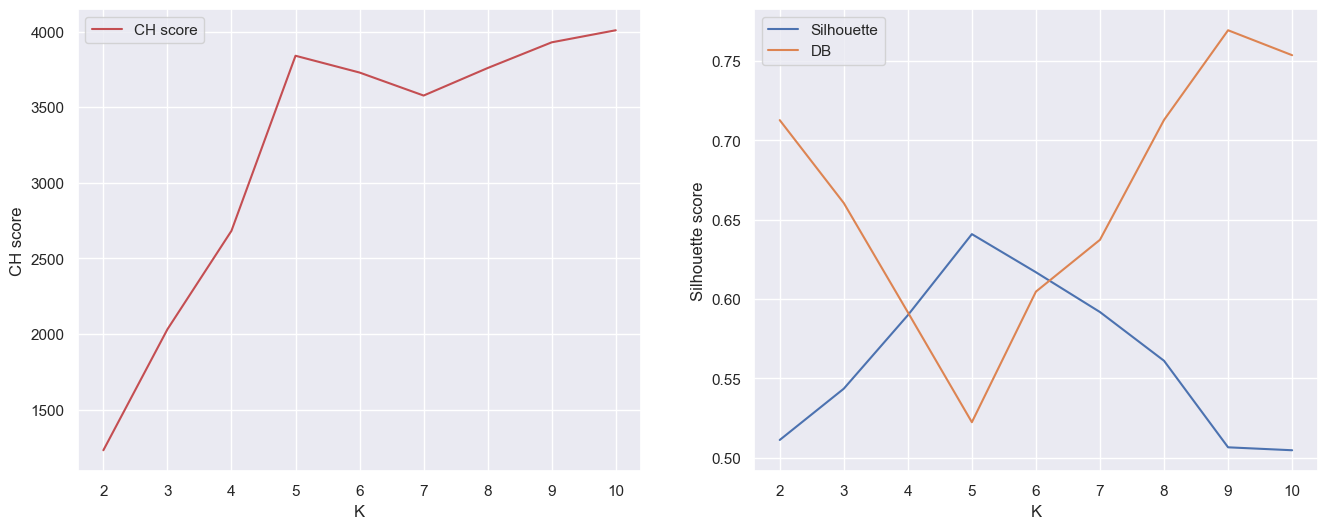

In [21]:
results_df2 = results_df2.sort_index()
results_df2 = results_df2.astype(float)

fig, ax = plt.subplots(1,2, figsize=(16,6))

sns.lineplot(x='K', y='CH score',data=results_df2.reset_index(),label='CH score', color='r', ax=ax[0]);
sns.lineplot(x='K', y='Silhouette score',data=results_df2.reset_index(),label='Silhouette',ax=ax[1]);
sns.lineplot(x='K', y='DB score',data=results_df2.reset_index(),label='DB');


But the real *shape* of the clusters cannot be captured, because k-means only "sees" spherical clusters and these are ellipsoidal

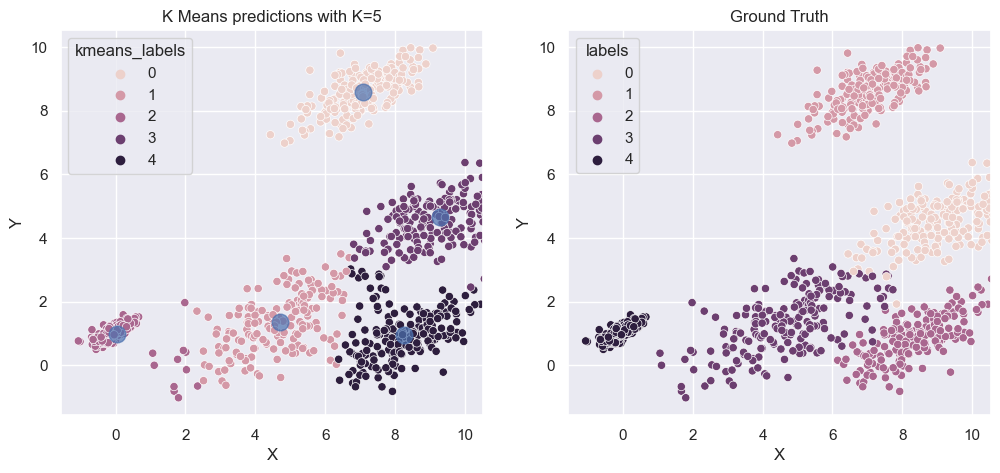

In [22]:
K=5
kmeans = KMeans(n_clusters=K, max_iter=100)
kmeans.fit(data.loc[:,['X','Y']]);
data['kmeans_labels'] = kmeans.labels_

fix, axes = plt.subplots(1,2,figsize=(12,5))

# Plot results
sns.scatterplot(x='X', y='Y', hue='kmeans_labels', data=data,ax=axes[0]);

axes[0].set_xlim(axes[0].get_ylim())
axes[0].plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 'bo', markersize=12,alpha=0.7);
axes[0].set_title('K Means predictions with K={}'.format(K));

sns.scatterplot(x='X', y='Y',hue='labels', data=data,ax=axes[1]);
axes[1].set_xlim(axes[1].get_ylim())
axes[1].set_title('Ground Truth');

plt.show();

Now we will try EM mixture of gaussians models to try to get a better clustering.

**EM Mixture of Gaussians**

This method performs E-M for mixture densities, including mixtures of Gaussians
we can specify which family of gaussians we intend to fit:

* "full" each component has full covariance matrix, 
* "diagonal" covariances are diagonal (just variance), 
*  "spherical"  each component has his own diagonal univariance and "tied" all components share variance

    WARNING: default is "full".

 suppose first that we specify axis-aligned densities (i.e., independent variables)

In [23]:
gm = GaussianMixture(n_components=5, covariance_type='diag').fit(data.loc[:,['X','Y']])
print('\nLOG Likelihood=', gm.lower_bound_)
print('\nWEIGHTS=')
pd.DataFrame(gm.weights_)
print('\nMEANS=')
pd.DataFrame(gm.means_)
print('\nCOV=')
pd.DataFrame(gm.covariances_)


LOG Likelihood= -3.6627415107853722

WEIGHTS=


0
0  0.200
1  0.182
2  0.199
3  0.201
4  0.218


MEANS=


0      1
0  7.093  8.606
1  8.404  0.909
2 -0.085  1.037
3  9.260  4.595
4  4.842  1.249


COV=


0      1
0  0.769  0.382
1  0.658  0.382
2  0.093  0.045
3  1.286  0.799
4  2.225  0.965

 This is a graphical summary of the clustering

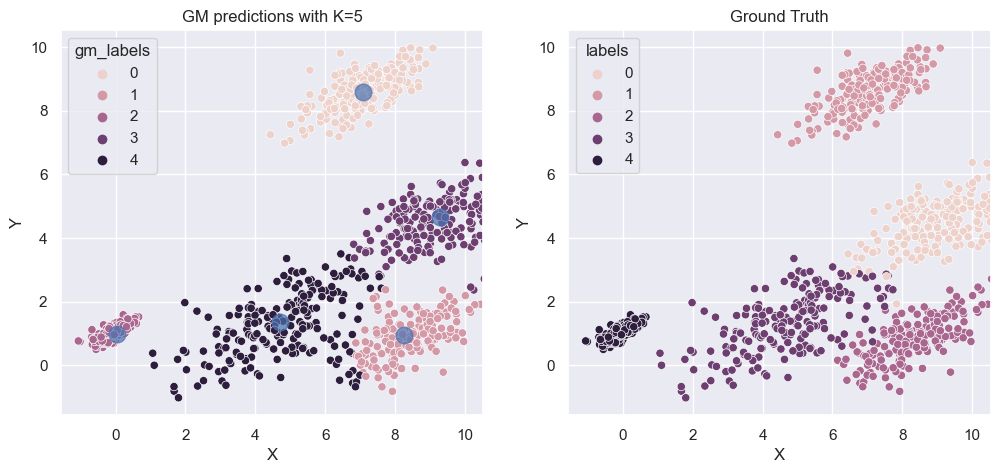

In [24]:
data['gm_labels'] = gm.predict(data.loc[:,['X','Y']])

fix, axes = plt.subplots(1,2,figsize=(12,5))

# Plot results
sns.scatterplot(x='X', y='Y', hue='gm_labels', data=data,ax=axes[0]);

axes[0].set_xlim(axes[0].get_ylim())
axes[0].plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 'bo', markersize=12,alpha=0.7);
axes[0].set_title('GM predictions with K={}'.format(5));

sns.scatterplot(x='X', y='Y',hue='labels', data=data,ax=axes[1]);
axes[1].set_xlim(axes[1].get_ylim())
axes[1].set_title('Ground Truth');

plt.show();

 it was very likely that E-M performed extremely well
 why? because we knew the truth (cluster form and number)

 suppose now we fit general gaussians

In [25]:
gm =GaussianMixture(n_components=5, covariance_type='full').fit(data.loc[:,['X','Y']])
print('\nLOG Likelihood=', gm.lower_bound_)
print('\nWEIGHTS=')
pd.DataFrame(gm.weights_)
print('\nMEANS=')
pd.DataFrame(gm.means_)
print('\nCOV=')
gm.covariances_


LOG Likelihood= -3.3727775836513527

WEIGHTS=


0
0  0.200
1  0.197
2  0.202
3  0.200
4  0.200


MEANS=


0      1
0  4.680  1.380
1  9.204  4.630
2  8.353  0.842
3  7.093  8.606
4 -0.084  1.038


COV=


array([[[1.92629457, 0.89877823],
        [0.89877823, 0.92993581]],

       [[1.34895746, 0.65488148],
        [0.65488148, 0.73320034]],

       [[0.877328  , 0.423405  ],
        [0.423405  , 0.43820981]],

       [[0.76905213, 0.36600253],
        [0.36600253, 0.38250811]],

       [[0.09403824, 0.05038903],
        [0.05038903, 0.04514989]]])

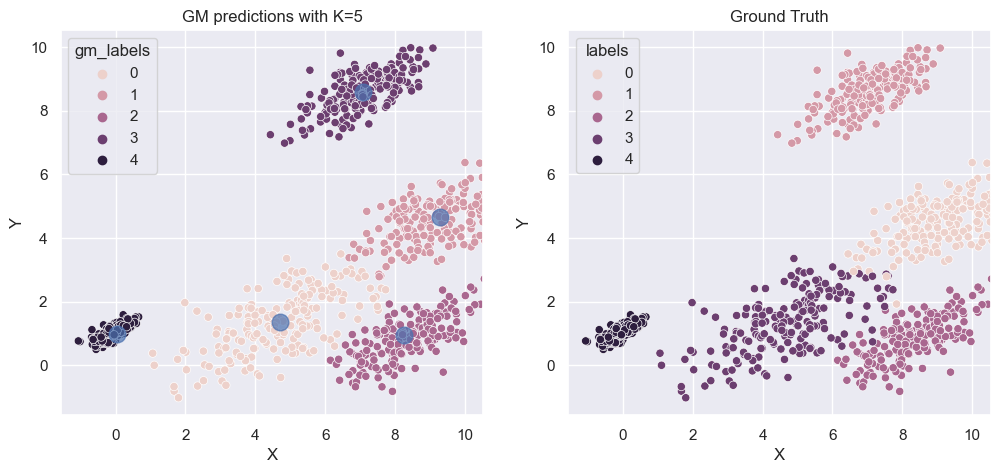

In [26]:
data['gm_labels'] = gm.predict(data.loc[:,['X','Y']])

fix, axes = plt.subplots(1,2,figsize=(12,5))

# Plot results
sns.scatterplot(x='X', y='Y', hue='gm_labels', data=data,ax=axes[0]);
axes[0].set_xlim(axes[0].get_ylim())
axes[0].plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 'bo', markersize=12,alpha=0.7);
axes[0].set_title('GM predictions with K=5');

sns.scatterplot(x='X', y='Y',hue='labels', data=data,ax=axes[1]);
axes[1].set_xlim(axes[1].get_ylim())
axes[1].set_title('Ground Truth');

plt.show();

 the method works very smoothly
 why? because the data *is* gaussian

compare the estimated centers with the truth (note the clusters may appear in a different order)

In [27]:
pd.concat({'Estimated Means':pd.DataFrame(gm.means_).sort_values(by=0,ignore_index=True), 'Truth means':pd.DataFrame(mu_k).sort_values(by=0,ignore_index=True)},axis=1)

Estimated Means        Truth means       
                0      1           0      1
0          -0.084  1.038      -0.105  1.025
1           4.680  1.380       4.599  1.446
2           7.093  8.606       7.135  8.680
3           8.353  0.842       8.361  0.803
4           9.204  4.630       9.220  4.729

or the estimated coefficients  with the truth 

In [28]:
c= Counter(labels)
pd.DataFrame({'estimated coefficients':gm.weights_, 'truth': np.array([c[v] for v in c])/N})

estimated coefficients  truth
0                   0.200    0.2
1                   0.197    0.2
2                   0.202    0.2
3                   0.200    0.2
4                   0.200    0.2

We can see that our model has found the real clusters of our data almost perfectly. 

Mixture of gaussians can return the clusters as an array of probability of belonging to each of the possible clusters, so we can see now "how sure" is our model about its predictions for each class. These are what we called _soft assignments_ in class.

As you can see on these plots, the model is more sure about the predictions of "easy" clusters and it is less sure about the predictions of difficult ones. 

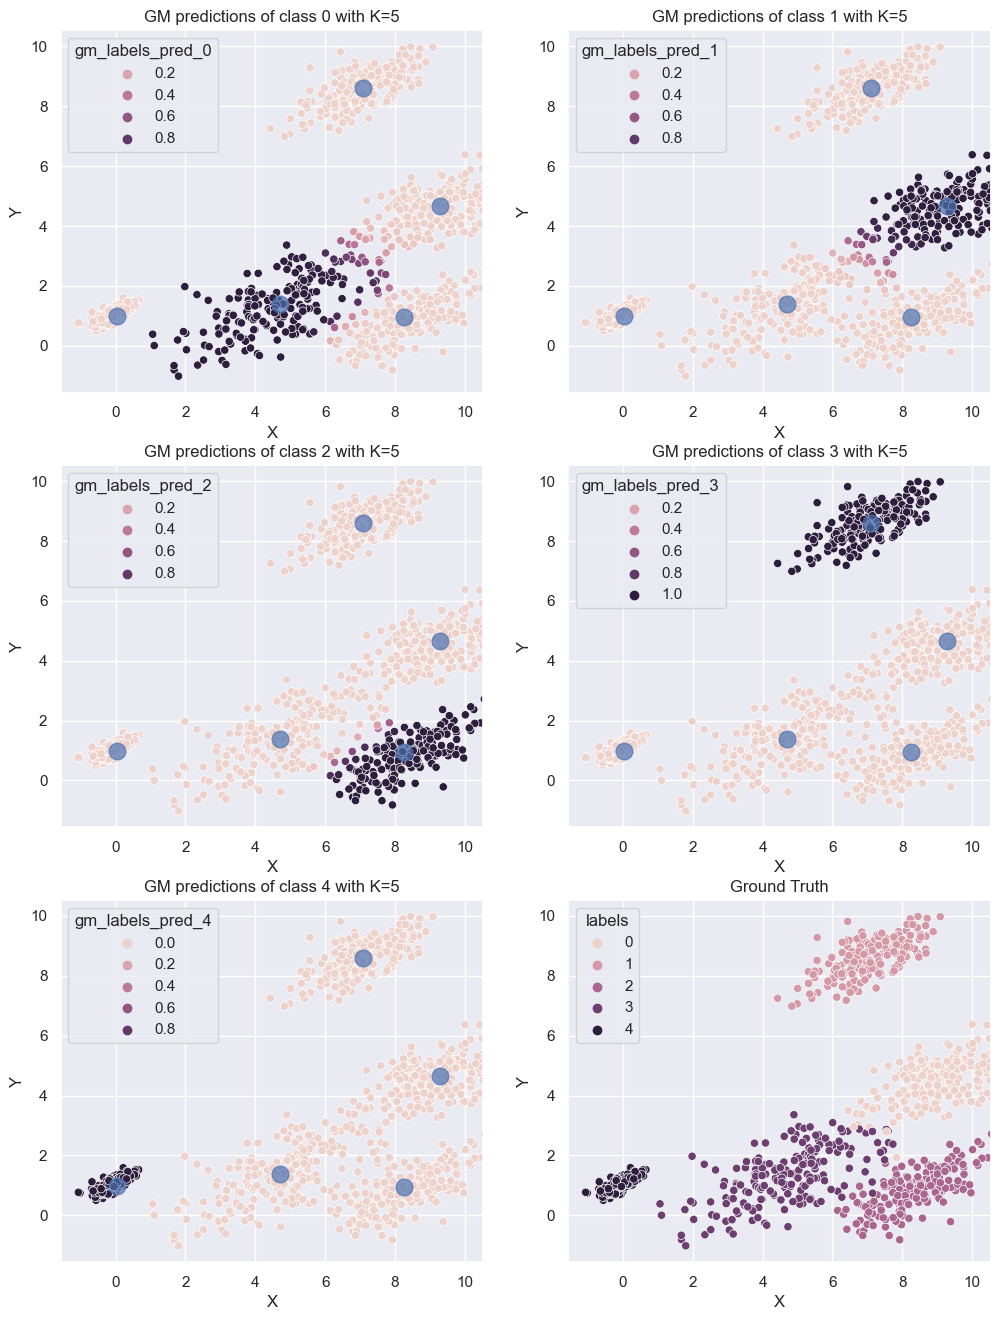

In [29]:
prob_prediction = gm.predict_proba(data.loc[:,['X','Y']])
data['gm_labels_pred_0'] = prob_prediction[:,0]
data['gm_labels_pred_1'] = prob_prediction[:,1]
data['gm_labels_pred_2'] = prob_prediction[:,2]
data['gm_labels_pred_3'] = prob_prediction[:,3]
data['gm_labels_pred_4'] = prob_prediction[:,4]

fix, axes = plt.subplots(3,2,figsize=(12,16))
axes = axes.reshape(-1)
# Plot results
for i in range(0,5):
    sns.scatterplot(x='X', y='Y', hue=f'gm_labels_pred_{i}', data=data,ax=axes[i]);
    axes[i].set_xlim(axes[0].get_ylim())
    axes[i].plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 'bo', markersize=12,alpha=0.7);
    axes[i].set_title(f'GM predictions of class {i} with K=5');
sns.scatterplot(x='X', y='Y',hue='labels', data=data, ax=axes[-1]);
axes[-1].set_xlim(axes[1].get_ylim())
axes[-1].set_title('Ground Truth');
plt.show();

## SECTION 3. Real life example

Now we are going to try these models on a real dataset. We will be using the fashion mnist dataset, a small image dataset for clasification. The idea for using this
labelled dataset (meant for classification) is that we can view the classes as forming clusters, so we can in a way evaluate the results of the clustering algorithms. In essence, we will see whether clusters found contain images belonging to the same type of pictures.

In [30]:
labels_names={0:"T-shirt/top",
1:"Trouser",
2:"Pullover",
3:"Dress",
4:"Coat",
5:"Sandal",
6:"Shirt",
7:"Sneaker",
8:"Bag",
9:"Ankle boot"}

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

h= 28
w=28
n = x_test.shape[0]
real_k = 10

data = x_test.reshape(n, h*w)   # rows are images, columns are (flattened) pixel values
labels = np.array(list(map(labels_names.get, y_test)))

Here we can see a subset of our data. There are classes looking quite similar and classes that look completely different.

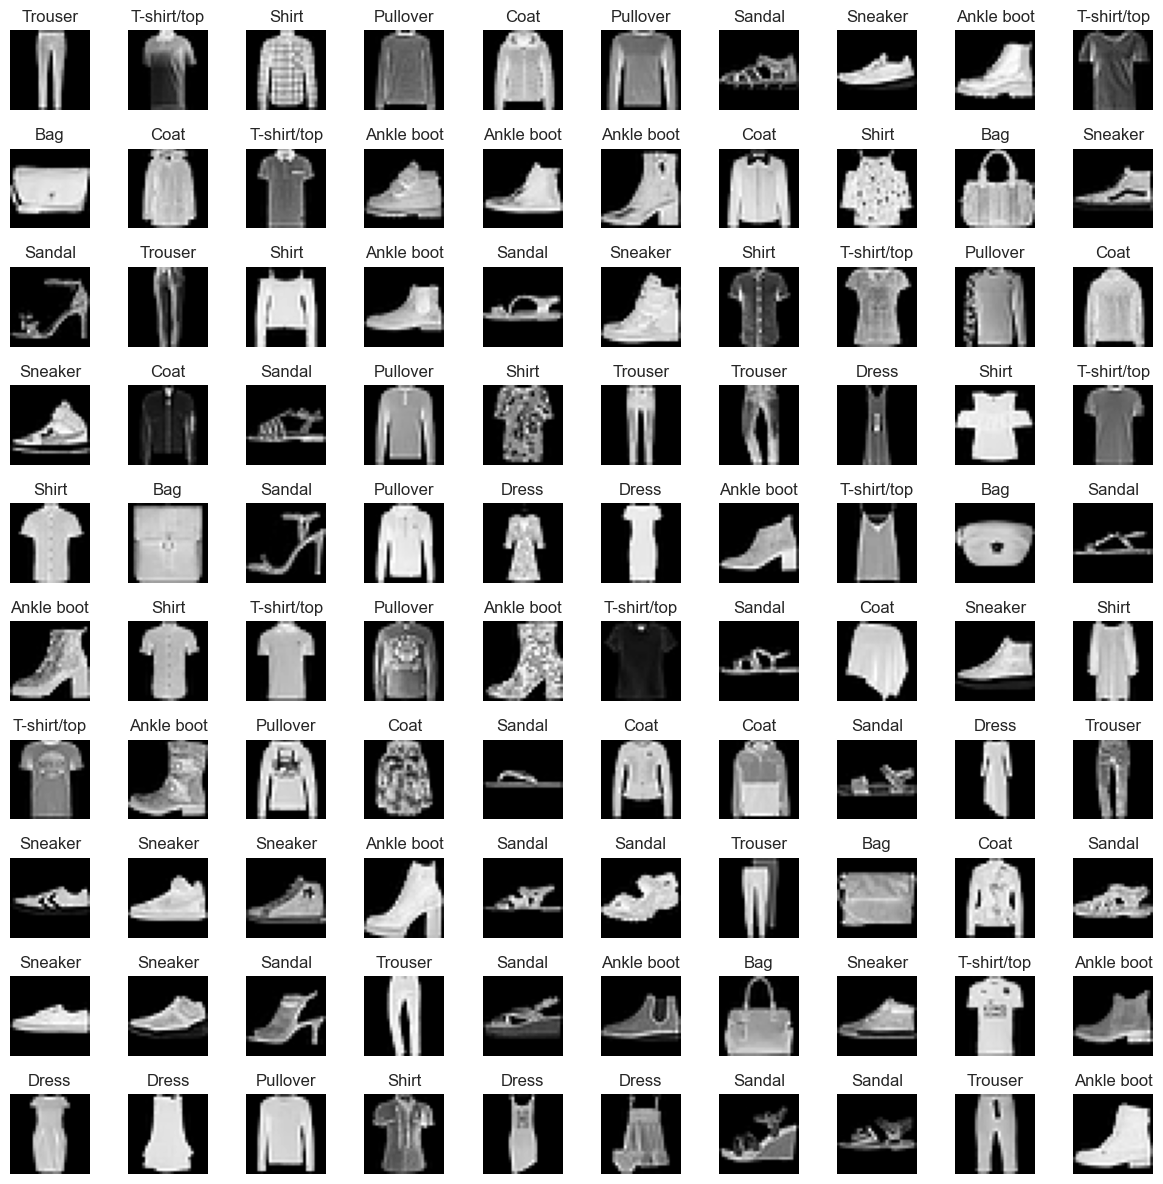

In [31]:
def plot_random_subset_of_data(data,labels):
    fig, axes = plt.subplots(10,10,figsize=(12, 12));
    axes = axes.reshape(-1);
    for i in range(10*10):
        idx = np.random.randint(data.shape[0]);  
        axes[i].imshow(data[idx,:].reshape(h,w), cmap=plt.cm.gray);
        axes[i].set_title(labels[idx]);
        axes[i].set_axis_off();
    fig.tight_layout();
    plt.show();
    
plot_random_subset_of_data(data,labels)

We will try first to find clusters with K means. A priori we don't know how to set K (well we do know that there are 10 classes however some of these may be clustered together if they are "similar"). So we are going to try out different K values. 

Our data is composed by small images, the shape of these images could not be ideal for a kmeans model (based on distances). 

We can see in the heatmap of our data that images have strong patterns, this is probably consequence of the black background of our samples (pixel value codified as 0). 

Also, pixel ranges are quite wide, it could be a good idea to scale them. 

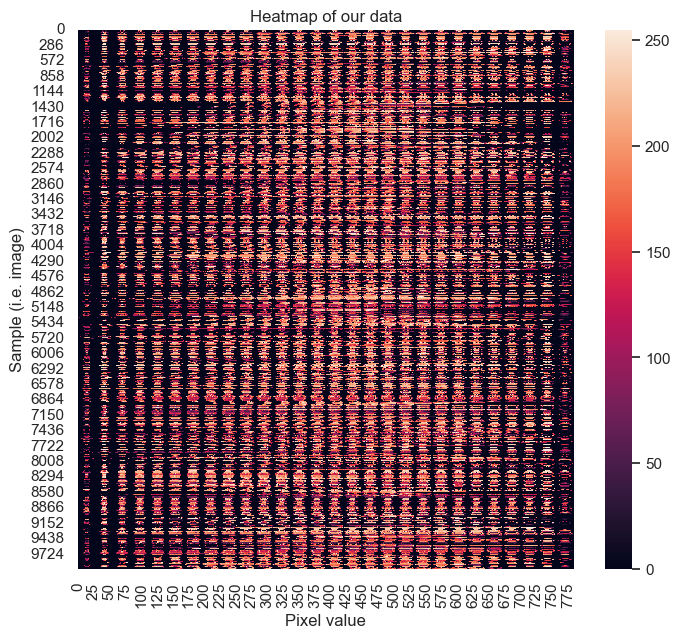

In [32]:
plt.figure(figsize=(8,7));
sns.heatmap(data);
plt.title('Heatmap of our data');
plt.xlabel('Pixel value');
plt.ylabel('Sample (i.e. image)');

To fix these problems we are going to use PCA. By using PCA on our preprocessing we obtain a denser dataset and reduce the number of variables. It also is controling the range.

In [33]:
pca = PCA();
# We scale the data to improve PCA performance. 
pca.fit(minmax_scale(data));
components = np.sum(np.cumsum(pca.explained_variance_ratio_) <= 0.9)
print(f'If we maintain 90% of the variance we obtain {components} principal components, not bad at all!')
pca = PCA(n_components=components);
data_pca = pca.fit_transform(minmax_scale(data));

print('Original shape:', data.shape,'New shape:',data_pca.shape)

PCA()

If we maintain 90% of the variance we obtain 82 principal components, not bad at all!
Original shape: (10000, 784) New shape: (10000, 82)


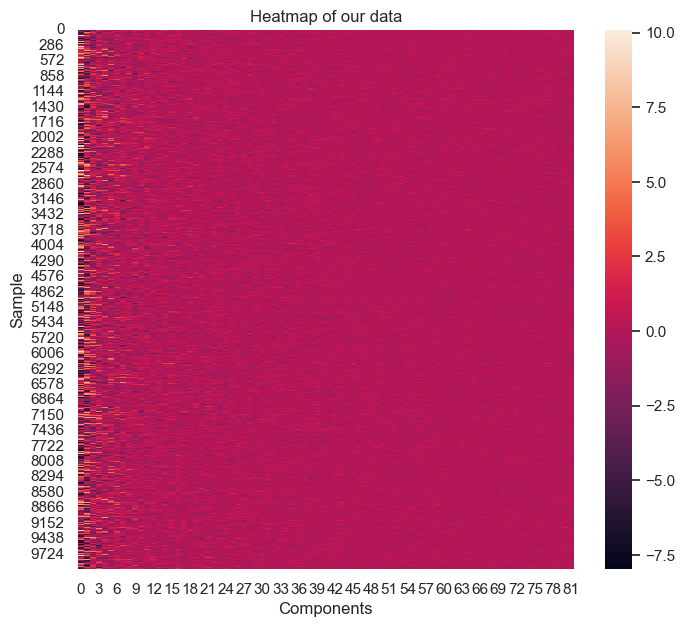

In [34]:
plt.figure(figsize=(8,7));
sns.heatmap(data_pca);
plt.title('Heatmap of our data');
plt.xlabel('Components');
plt.ylabel('Sample');

Now that we have processed the data we can try our first model. 

In [35]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'K'))

results_df3 = pd.DataFrame(index=index, columns= ['CH score', 'Silhouette score', 'DB score']);

for k in [2, 5, 10, 15]:
    #init_train_time = time();
    kmeans = KMeans(n_clusters=k,max_iter=1000);
    kmeans.fit(data_pca);
    #print('Training time for k={}: {}'.format(k, timedelta(seconds=time()-init_train_time)));

    CH = calinski_harabasz_score(data, kmeans.labels_ );
    S = silhouette_score(data, kmeans.labels_ );
    DB = davies_bouldin_score(data, kmeans.labels_ );
    
    results_df3.loc[('kmeans', k),:] = [CH,S,DB];

KMeans(max_iter=1000, n_clusters=2)

KMeans(max_iter=1000, n_clusters=5)

KMeans(max_iter=1000, n_clusters=10)

KMeans(max_iter=1000, n_clusters=15)

In [36]:
results_df3.sort_values(by='CH score', ascending=False)

CH score Silhouette score DB score
model  K                                     
kmeans 2   2691.693            0.195    1.881
       5   1847.985            0.161     1.93
       10  1270.185            0.156    1.816
       15   990.732            0.127    2.106

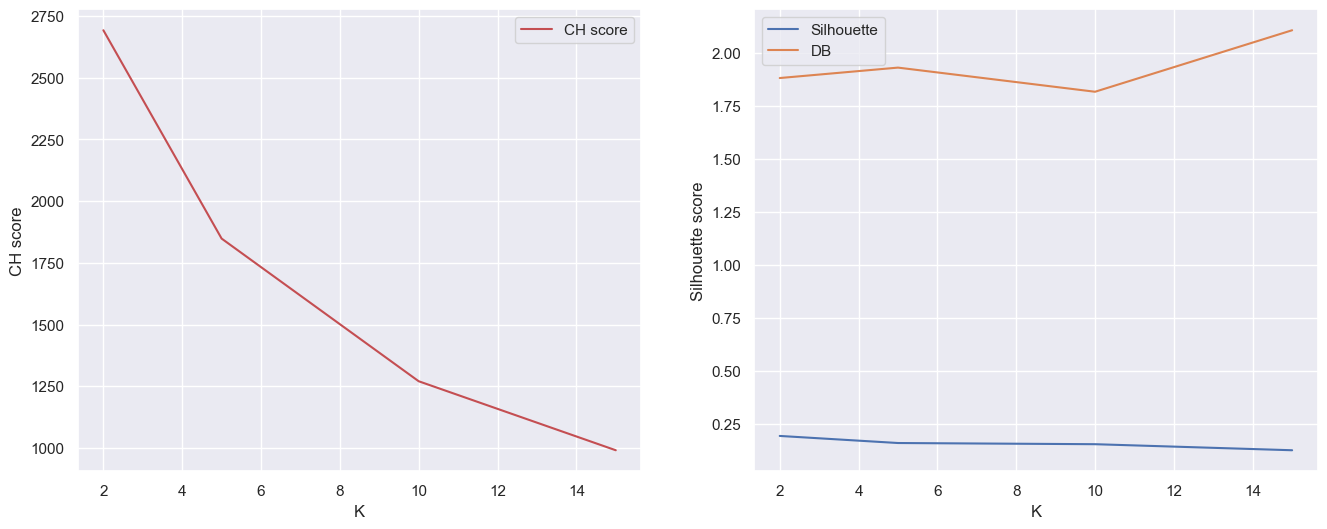

In [37]:
results_df3 = results_df3.sort_index()
results_df3 = results_df3.astype(float)

fig, ax = plt.subplots(1,2, figsize=(16,6))

sns.lineplot(x='K', y='CH score',data=results_df3.reset_index(),label='CH score', color='r', ax=ax[0]);
sns.lineplot(x='K', y='Silhouette score',data=results_df3.reset_index(),label='Silhouette',ax=ax[1]);
sns.lineplot(x='K', y='DB score',data=results_df3.reset_index(),label='DB');

Our metrics are not showing good results. It could be that our clusters are not making sense or that our metrics do not work well with our data. 

Accoriding to our metrics best k is k=2. We can now look at our clusters to see if they make any sense. Cluster analysis depends strongly of the kind of data you are working with, as we are clustering images the only way we have to check if the clusters make sense is to check sample images of each of the clusters.

In [38]:
kmeans = KMeans(n_clusters=2,max_iter=5000);
kmeans.fit(data_pca);

In [39]:
# In this case we have two clusters: 0 and 1
cluster_data1 = data[kmeans.labels_ == 1,:]
cluster_labels1 = labels[kmeans.labels_ == 1]
cluster_data0 = data[kmeans.labels_ == 0,:]
cluster_labels0 = labels[kmeans.labels_ == 0]


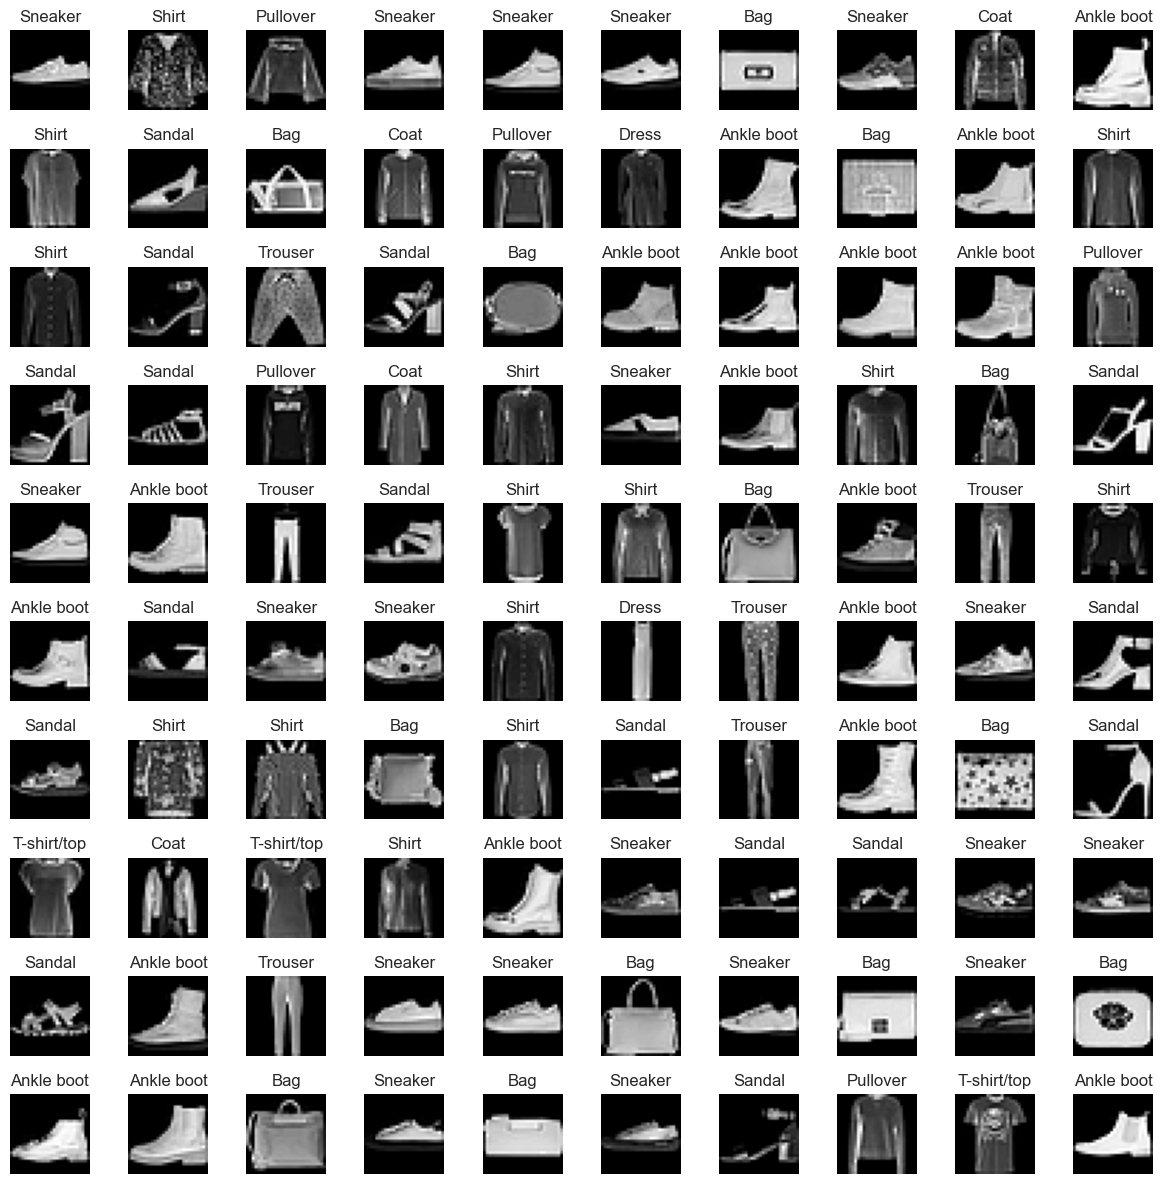

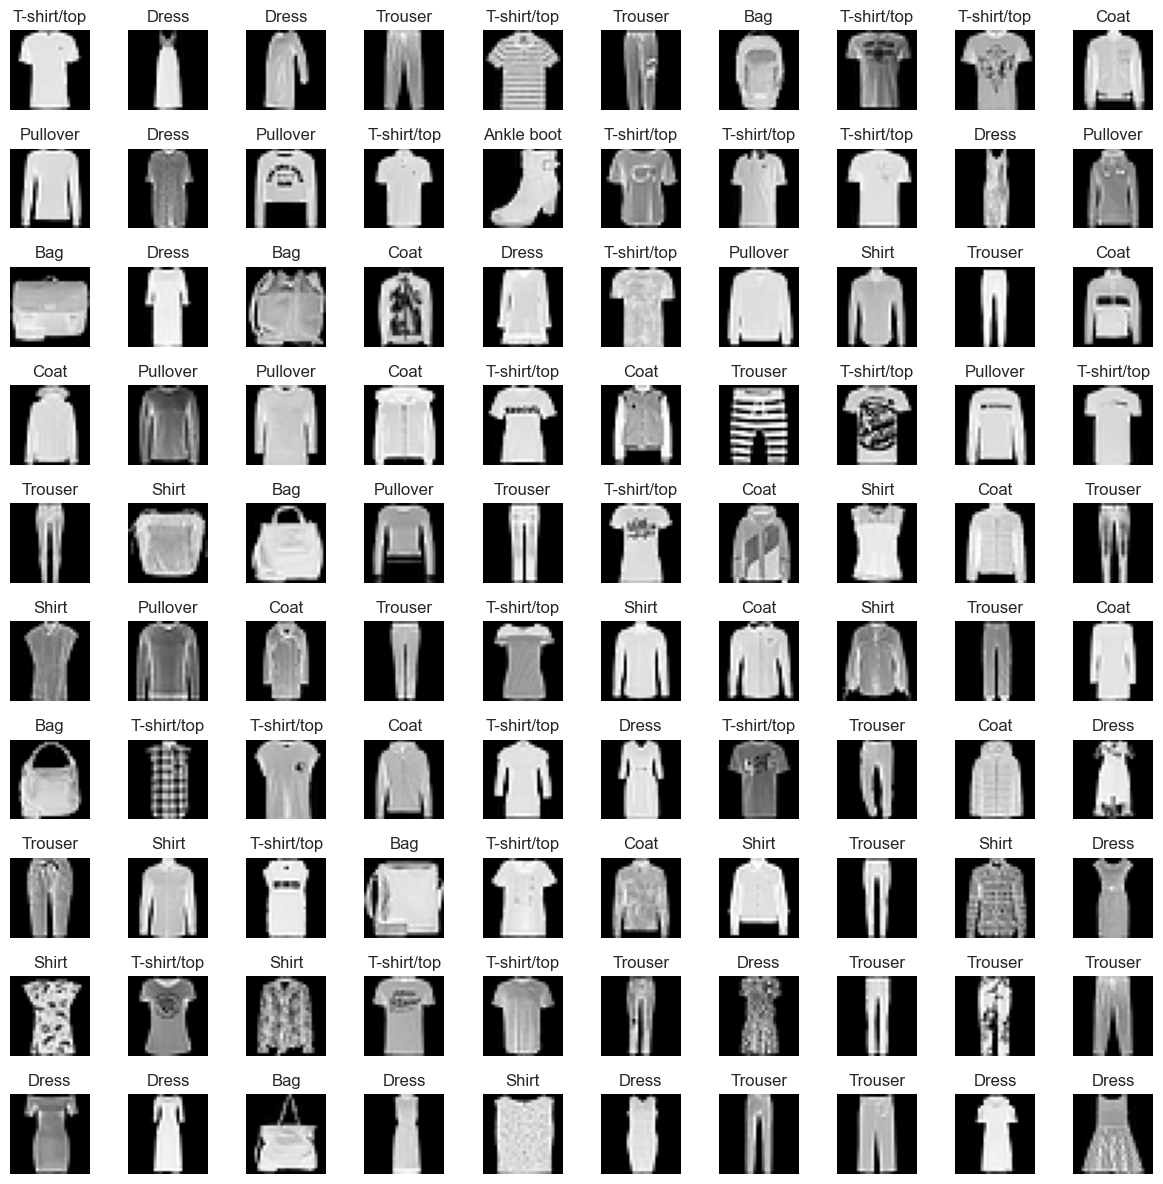

In [40]:

plot_random_subset_of_data(cluster_data0, cluster_labels0)
plot_random_subset_of_data(cluster_data1, cluster_labels1)


In this case it looks like the model has made the clustering based on "dark" vs "light" images.

We can use an histogram of the mean pixel value of our images to validate this theory. Darker images will be closer to zero and lighter images will be closer to 255.

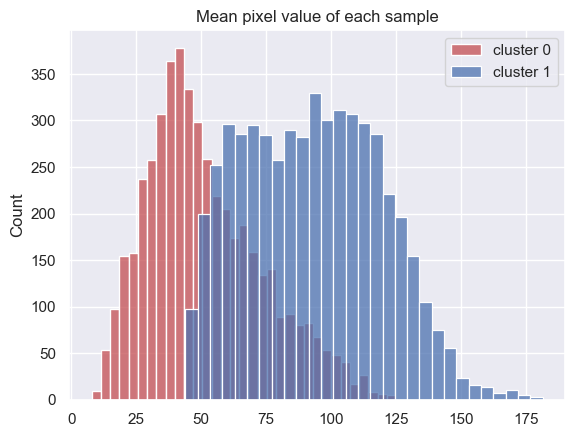

In [41]:
mean_pixel_value_by_image_cluster_1 = np.mean(data[kmeans.labels_ == 1,:],axis=1)
mean_pixel_value_by_image_cluster_0 = np.mean(data[kmeans.labels_ == 0,:],axis=1)

plt.title('Mean pixel value of each sample');
sns.histplot(mean_pixel_value_by_image_cluster_0,label='cluster 0',color='r');
sns.histplot(mean_pixel_value_by_image_cluster_1,label='cluster 1');
plt.legend();

We want a better/more complex clustering criteria. Let's try a Mixture of Gaussians model.
We will assume full covariance for a lack of further information.

In [42]:
for k in [2, 3, 5, 10, 15]:
    #init_train_time = time();
    gm = GaussianMixture(n_components=k, covariance_type='full')
    gm.fit(data_pca);
    #print('Trainin time for k={}: {}'.format(k, timedelta(seconds=time()-init_train_time)));
    prediction = gm.predict(data_pca) 
    CH = calinski_harabasz_score(data,prediction )
    S = silhouette_score(data, prediction)
    DB = davies_bouldin_score(data,prediction)
    
    results_df3.loc[('GM', k),:] = [CH,S,DB]

GaussianMixture(n_components=2)

GaussianMixture(n_components=3)

GaussianMixture(n_components=5)

GaussianMixture(n_components=10)

GaussianMixture(n_components=15)

In [43]:
results_df3.sort_values(by='CH score', ascending=False)

CH score  Silhouette score  DB score
model  K                                       
kmeans 2   2691.693             0.195     1.881
GM     2   2282.262             0.187     1.938
kmeans 5   1847.985             0.161     1.930
GM     3   1761.309             0.145     2.089
       5   1392.475             0.114     2.305
kmeans 10  1270.185             0.156     1.816
       15   990.732             0.127     2.106
GM     10   811.579             0.082     3.034
       15   667.116             0.078     3.586

It looks like the best k is 2 again. Also, our metrics were slightly better with kmeans. Let's see our clusters now.

In [44]:
gm =GaussianMixture(n_components=2, covariance_type='full')
gm.fit(data_pca);
prediction = gm.predict(data_pca) 
prob_prediction =  gm.predict_proba(data_pca)

GaussianMixture(n_components=2)

In [45]:
cluster_data0 = data[prediction == 0,:]
cluster_labels0 = labels[prediction == 0]
cluster_data1 = data[prediction == 1,:]
cluster_labels1 = labels[prediction == 1]

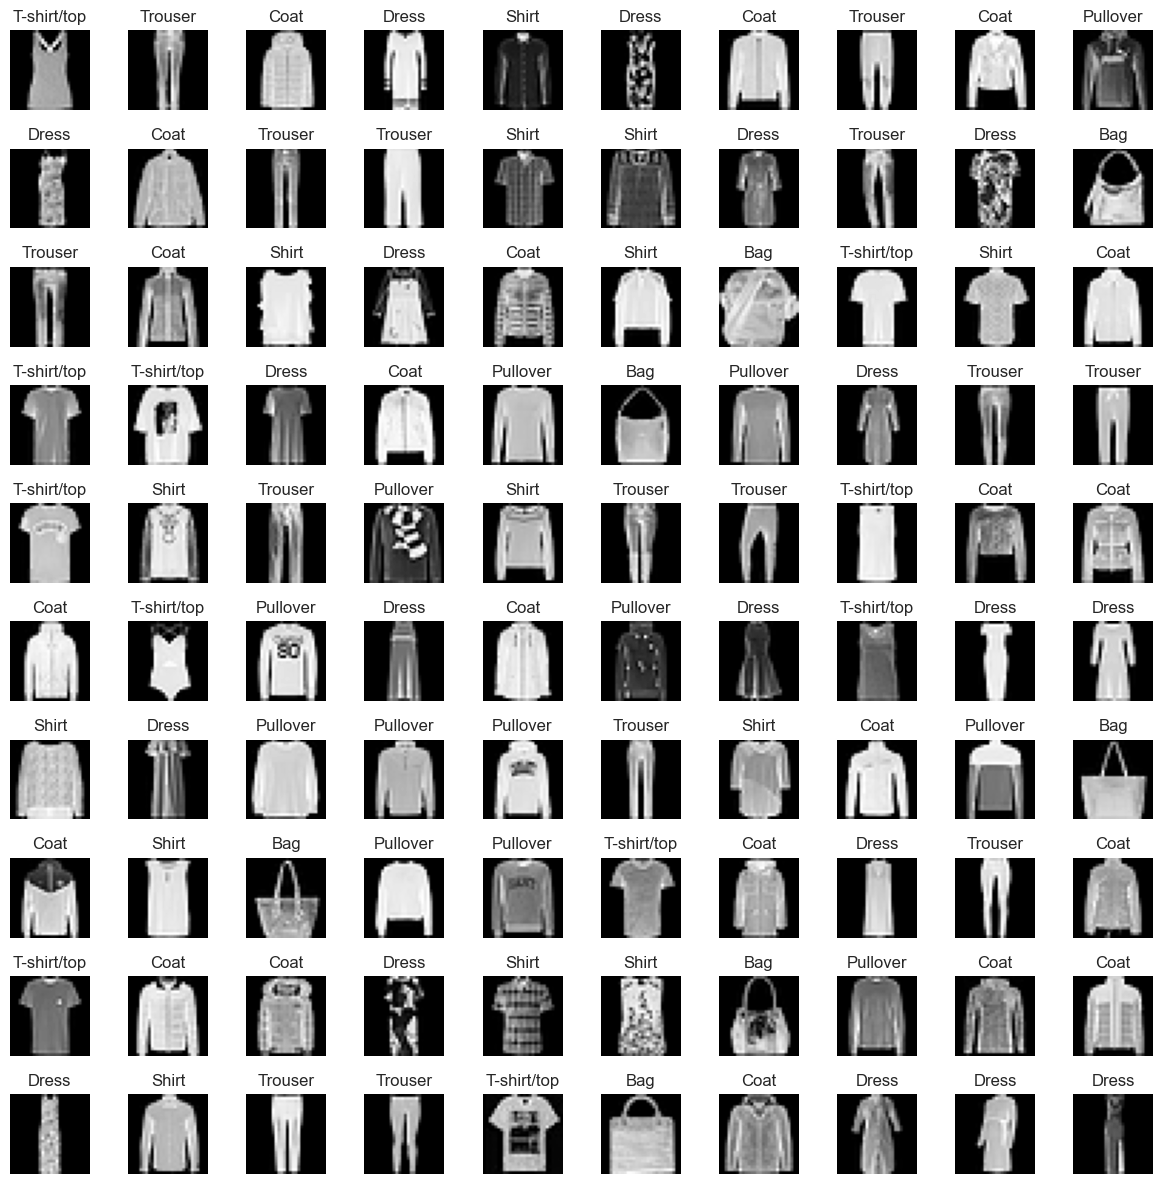

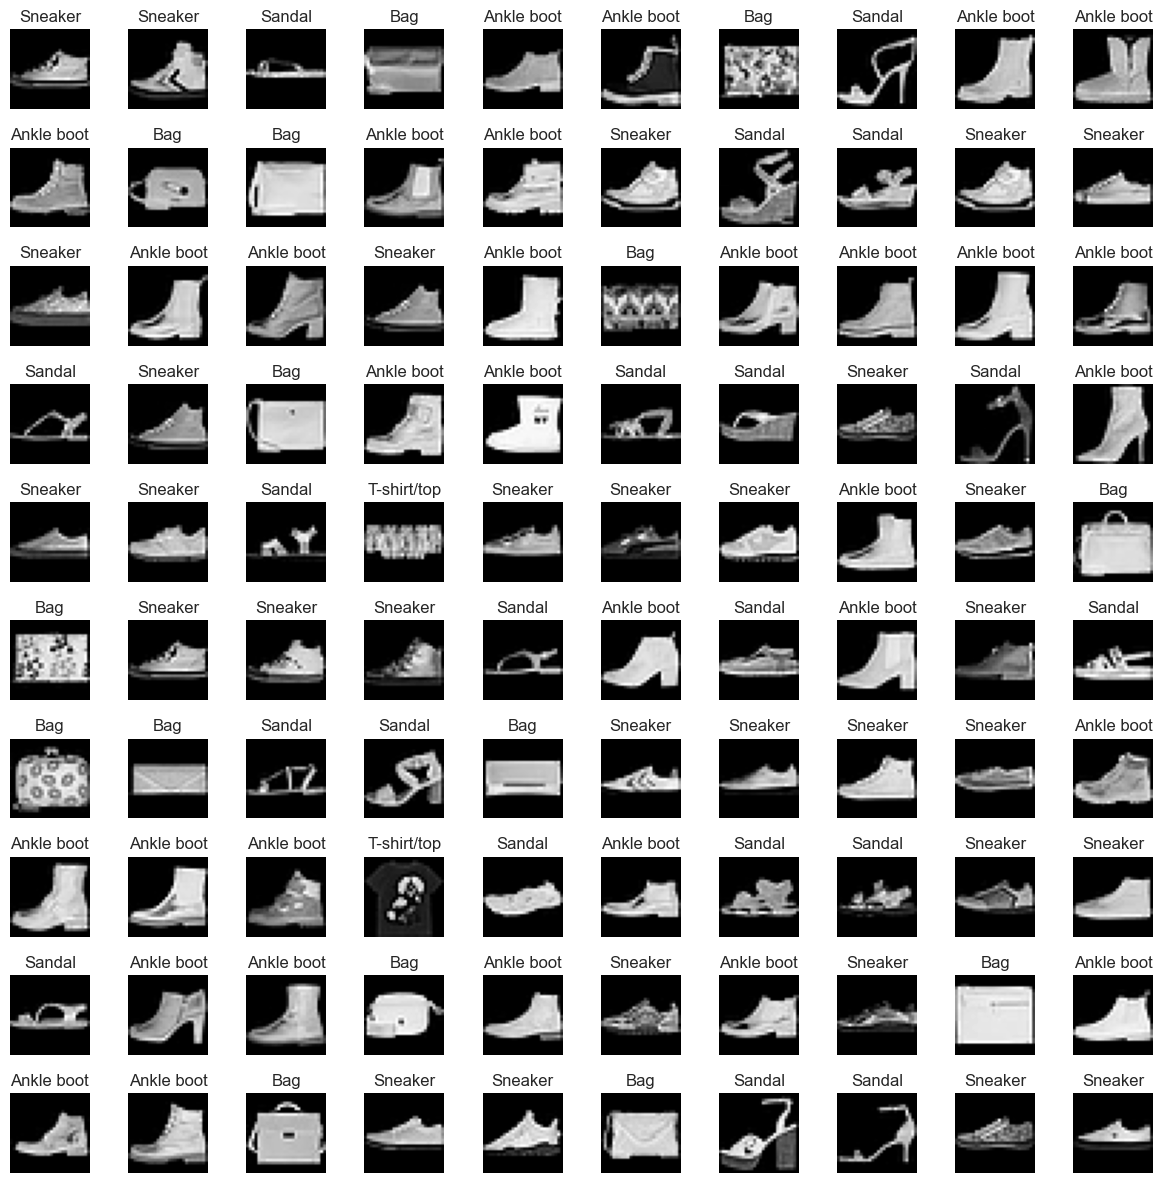

In [46]:

plot_random_subset_of_data(cluster_data0, cluster_labels0)
plot_random_subset_of_data(cluster_data1, cluster_labels1)

This time it looks like the model is separating shoes vs no shoes. Which is not bad taking into account that is using pixel data only. 
This time is more difficult to visualize our probabilities, so we are going to use two principal components to visualize them.

In our representation we can see a quite clear cluster separation, also our model looks to be quite sure of its predictions this time for almost all the samples.

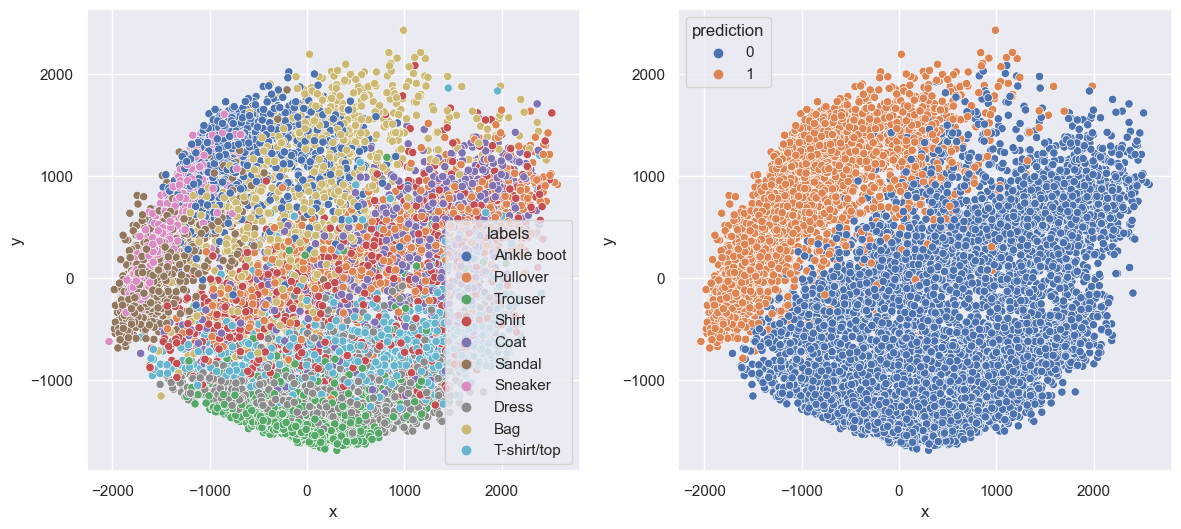

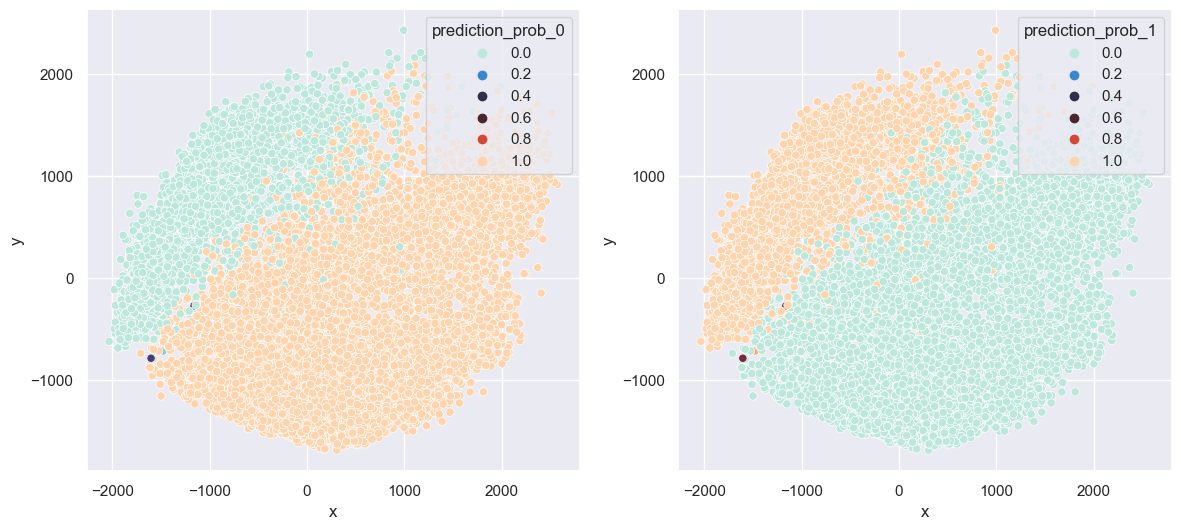

In [47]:
pca = PCA(n_components=2)
data_plot = pca.fit_transform(data)
data_plot = pd.DataFrame(data_plot,columns = ['x','y'])
data_plot['labels'] = labels
data_plot['prediction'] = prediction
data_plot['prediction_prob_0'] = prob_prediction[:,0]
data_plot['prediction_prob_1'] = prob_prediction[:,1]

prob_prediction =  gm.predict_proba(data_pca)

fig, axes = plt.subplots(1,2,figsize=(14,6));
sns.scatterplot(x='x',y='y', hue ='labels' , data=data_plot,ax=axes[0]);
sns.scatterplot(x='x',y='y', hue ='prediction' , data=data_plot,ax=axes[1]);

fig, axes = plt.subplots(1,2,figsize=(14,6));
sns.scatterplot(x='x',y='y', hue ='prediction_prob_0' , data=data_plot,ax=axes[0],palette='icefire');
sns.scatterplot(x='x',y='y', hue ='prediction_prob_1' , data=data_plot,ax=axes[1],palette='icefire');

Finally, as a curiosity we can see how the real labels of our samples would distribute on the clusters. It is nice that such a simple model has been able to separate the classes into clusters that make sense and has put samples of the same class on the same cluster most of the times.

In [48]:
pd.crosstab(labels, prediction)

col_0          0     1
row_0                 
Ankle boot     1   999
Bag          532   468
Coat         999     1
Dress        998     2
Pullover     999     1
Sandal         2   998
Shirt        990    10
Sneaker        0  1000
T-shirt/top  983    17
Trouser      998     2